# **STOCK PRICE PREDICTION USING LSTM**

In [ ]:
# Install required libraries
!pip install yfinance tensorflow numpy pandas matplotlib scikit-learn plotly --quiet


In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import plotly.graph_objs as go
from google.colab import files
import io

In [ ]:
# User Option
print("🔹 Choose one option:")
print("1️⃣  Download stock data automatically from Yahoo Finance")
print("2️⃣  Upload your own CSV dataset file")

choice = input("Enter your choice (1 or 2): ")

if choice == '1':
    # === Option 1: Download automatically ===
    TICKER = input("Enter stock symbol (e.g. AAPL, RELIANCE.NS): ") or "AAPL"
    START_DATE = input("Enter start date (YYYY-MM-DD): ") or "2015-01-01"
    END_DATE = input("Enter end date (YYYY-MM-DD): ") or "2025-11-08"

    df = yf.download(TICKER, start=START_DATE, end=END_DATE)
    df = df[['Close']]
    df.dropna(inplace=True)
    print(f" Downloaded {len(df)} rows for {TICKER}")
else:
    # === Option 2: User uploads CSV ===
    print("📁 Please upload your CSV file (must contain a 'Close' column).")
    uploaded = files.upload()
    for fn in uploaded.keys():
        filename = fn
    df = pd.read_csv(io.BytesIO(uploaded[filename]))
    print(f" Uploaded file: {filename}")
    # Try to find 'Close' column
    if 'Close' not in df.columns:
        raise ValueError(" Your dataset must have a column named 'Close'.")
    print(f" Loaded {len(df)} rows from uploaded dataset.")

# Displaying first few rows
df.head()

🔹 Choose one option:
1️⃣  Download stock data automatically from Yahoo Finance
2️⃣  Upload your own CSV dataset file
Enter your choice (1 or 2): 1
Enter stock symbol (e.g. AAPL, RELIANCE.NS): AAPL
Enter start date (YYYY-MM-DD): 
Enter end date (YYYY-MM-DD): 


/tmp/ipython-input-3286093227.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed

✅ Downloaded 2730 rows for AAPL


Price,Close
Ticker,AAPL
Date,
2015-01-02,24.261044
2015-01-05,23.577568
2015-01-06,23.579790
2015-01-07,23.910431
2015-01-08,24.829124


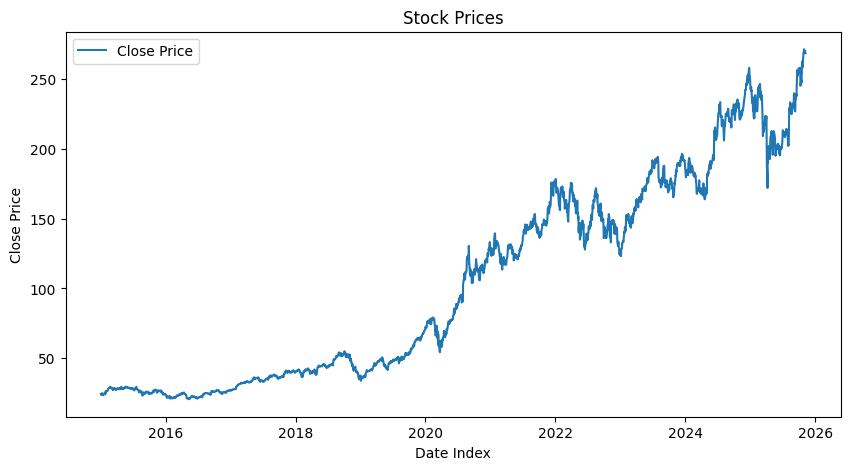

In [ ]:
# Visualize data
plt.figure(figsize=(10,5))
plt.plot(df['Close'], label='Close Price')
plt.title('Stock Prices')
plt.xlabel('Date Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [ ]:
# Preprocessing the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df[['Close']])

window_size = 60
X, y = [], []
for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i-window_size:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")

Train samples: 2136, Test samples: 534


In [ ]:
# Build LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1)

# Evaluate the model
predictions = model.predict(X_test)
predictions_inv = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))

mse = mean_squared_error(y_test_inv, predictions_inv)
mae = mean_absolute_error(y_test_inv, predictions_inv)
print(f" Test MSE: {mse:.4f}, MAE: {mae:.4f}")

Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - loss: 0.0176 - mae: 0.0832 - val_loss: 0.0042 - val_mae: 0.0561
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0014 - mae: 0.0242 - val_loss: 0.0043 - val_mae: 0.0565
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0012 - mae: 0.0221 - val_loss: 0.0033 - val_mae: 0.0476
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 9.4427e-04 - mae: 0.0189 - val_loss: 0.0041 - val_mae: 0.0552
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 8.7201e-04 - mae: 0.0186 - val_loss: 0.0012 - val_mae: 0.0274
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 9.5407e-04 - mae: 0.0195 - val_loss: 0.0049 - val_mae: 0.0616
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 7.7660e-04 - mae: 0.0182 - val_loss: 0.0046 - val_mae: 0.0596
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 7.8941e-04 - mae: 0.0189 - val_loss: 0.0066 - val_mae: 0.0741
Epoch 9/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 71m

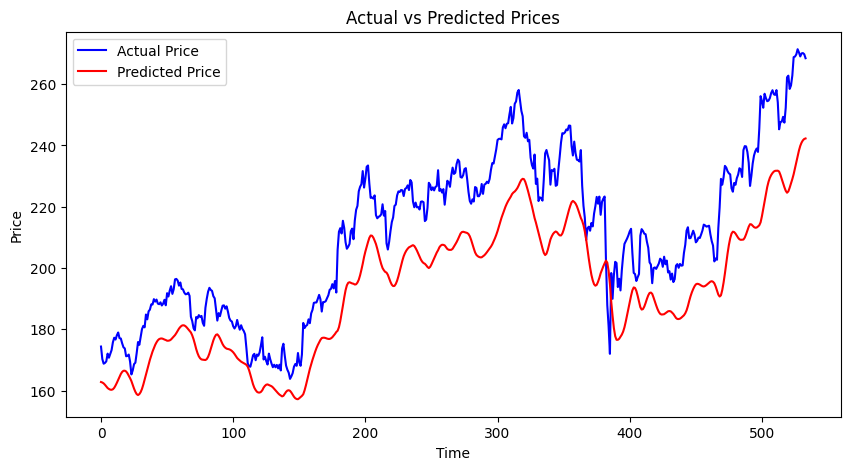

In [ ]:
# Plot Actual vs Predicted
plt.figure(figsize=(10,5))
plt.plot(y_test_inv, color='blue', label='Actual Price')
plt.plot(predictions_inv, color='red', label='Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
# Predict next-day price
last_60 = scaled_data[-window_size:]
next_input = np.reshape(last_60, (1, window_size, 1))
next_pred_scaled = model.predict(next_input)
next_pred = scaler.inverse_transform(next_pred_scaled)
print(f"📊 Predicted next-day closing price: {next_pred[0][0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
📊 Predicted next-day closing price: 242.15


In [ ]:
# Interactive plot
fig = go.Figure()
fig.add_trace(go.Scatter(y=y_test_inv.ravel(), mode='lines', name='Actual'))
fig.add_trace(go.Scatter(y=predictions_inv.ravel(), mode='lines', name='Predicted'))
fig.update_layout(title="LSTM Stock Price Prediction",
                  xaxis_title='Days',
                  yaxis_title='Price')
fig.show()